## Get Pypower working

In [1]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
import matplotlib as mpl
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck18 as cosmo
from astropy.stats import scott_bin_width
from scipy.interpolate import InterpolatedUnivariateSpline
# from pypower import CatalogFFTPower
from tqdm import tqdm

# Set plotting style (optional, requires a style file)
mpl.style.use('./style.mcstyle')

In [2]:
def sky_to_xyz(rdz, cosmology):
    """
    Converts sky coordinates (ra, dec, z) to Cartesian coordinates (x, y, z).
    """
    ra, dec, z = np.asarray(rdz).T
    coords = SkyCoord(ra=ra*u.deg, dec=dec*u.deg,
                      distance=cosmology.comoving_distance(z))

    pos = coords.cartesian.xyz.to_value(u.Mpc) * cosmology.h
    return pos.T


def get_nofz(z, fsky, cosmo):
    """
    Calculates n(z) given redshift values and sky coverage fraction.
    This function estimates the comoving number density of objects as a
    function of redshift.
    """
    # Use Scott's rule to determine optimal bin width for the histogram
    _, edges = scott_bin_width(z, return_bins=True)

    # Count number of objects in each redshift bin
    dig = np.searchsorted(edges, z, "right")
    N = np.bincount(dig, minlength=len(edges)+1)[1:-1]

    # Calculate comoving volume of each spherical shell corresponding to a bin
    R_hi = cosmo.comoving_distance(edges[1:]).to_value(u.Mpc) * cosmo.h
    R_lo = cosmo.comoving_distance(edges[:-1]).to_value(u.Mpc) * cosmo.h
    dV = (4./3.) * np.pi * (R_hi**3 - R_lo**3) * fsky

    # Avoid division by zero for empty bins
    dV[dV == 0] = np.inf

    # Create a spline interpolator for n(z)
    nofz = InterpolatedUnivariateSpline(
        0.5*(edges[1:] + edges[:-1]), N/dV, ext='const')
    return nofz

In [37]:
# --- Configuration for Weighting ---
P0_FKP = 1e4      # Fiducial P(k) for FKP weights, in (Mpc/h)^3
fsky = 1./8         # Sky fraction of the survey, adjust as needed

# --- File Paths ---
data_file = '/anvil/scratch/x-mho1/cmass-ili/mtng/nbody/L3000-N384/0/mtng_lightcone/hod00000_aug00000.h5'
randoms_file = '/anvil/scratch/x-mho1/cmass-ili/abacus/randoms/L2000-N256/11/mtng_lightcone/hod00000_aug00000.h5'

# --- Load Raw Data (RA, Dec, Redshift) ---
with h5py.File(data_file, 'r') as f:
    data_rdz = np.array([f['ra'][:], f['dec'][:], f['z'][:]]).T
with h5py.File(randoms_file, 'r') as f:
    randoms_rdz = np.array([f['ra'][:], f['dec'][:], f['z'][:]]).T

print(f"Loaded {len(data_rdz)} data galaxies and {len(randoms_rdz)} randoms.")

# --- Prepare Position Arrays ---
data_positions = sky_to_xyz(data_rdz, cosmo).T
randoms_positions = sky_to_xyz(randoms_rdz, cosmo).T

# --- Prepare All Potential Weight Arrays ---
# 1. Uniform weights
uniform_data_weights = np.ones(data_positions.shape[1])
uniform_randoms_weights = np.ones(randoms_positions.shape[1])

# 2. FKP weights
print(f"Pre-calculating FKP weights with P0 = {P0_FKP}...")
nofz_estimator = get_nofz(data_rdz[:, 2], fsky=fsky, cosmo=cosmo)
n_data = nofz_estimator(data_rdz[:, 2])
n_randoms = nofz_estimator(randoms_rdz[:, 2])
fkp_data_weights = 1.0 / (1.0 + n_data * P0_FKP)
fkp_randoms_weights = 1.0 / (1.0 + n_randoms * P0_FKP)
print("FKP weights are ready.")

Loaded 790149 data galaxies and 530539 randoms.
Pre-calculating FKP weights with P0 = 10000.0...
FKP weights are ready.


In [46]:
# --- 1. Define Default Parameters ---
default_params = dict(
    use_fkp=False,
    resampler='tsc',
    interlacing=2,
    cellsize=1000/128,
    boxpad=1.2,
    los='x',
    position_type='xyz'
)

# --- 2. Define Specific Configurations ---
# You can now directly compare weighted vs. unweighted runs.
configs = [
    dict(name=r'$P_0=$1e4',
         params=dict(use_fkp=True)),
]

# --- 3. Run Calculations and Store Results ---
# results = {}
kedges = np.arange(0, 0.5, 0.00314)
ells = (0, 2, 4)

for config in tqdm(configs):
    name = config['name']

    # Create the final parameters by updating defaults with specific changes
    final_params = default_params.copy()
    final_params.update(config['params'])

    # Pop 'use_fkp' as it's not a pypower argument, and select weights
    if final_params.pop('use_fkp'):
        print(f"--- Running: {name} (using FKP weights) ---")
        data_w, randoms_w = fkp_data_weights, fkp_randoms_weights
    else:
        print(f"--- Running: {name} (using Uniform weights) ---")
        data_w, randoms_w = uniform_data_weights, uniform_randoms_weights

    result = CatalogFFTPower(
        data_positions1=data_positions,
        data_weights1=data_w,
        randoms_positions1=randoms_positions,
        randoms_weights1=randoms_w,
        edges=kedges,
        ells=ells,
        **final_params  # Unpack the remaining, valid pypower parameters
    )
    results[name] = result.poles

  0%|          | 0/1 [00:00<?, ?it/s]

--- Running: $P_0=$1e4 (using FKP weights) ---


100%|██████████| 1/1 [00:06<00:00,  6.58s/it]


$P_0=$1e4 (Baseline)
$P_0=$1e5


/home/x-mho1/.conda/envs/2024.02-py311/pmesh/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/x-mho1/.conda/envs/2024.02-py311/pmesh/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/x-mho1/.conda/envs/2024.02-py311/pmesh/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/x-mho1/.conda/envs/2024.02-py311/pmesh/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


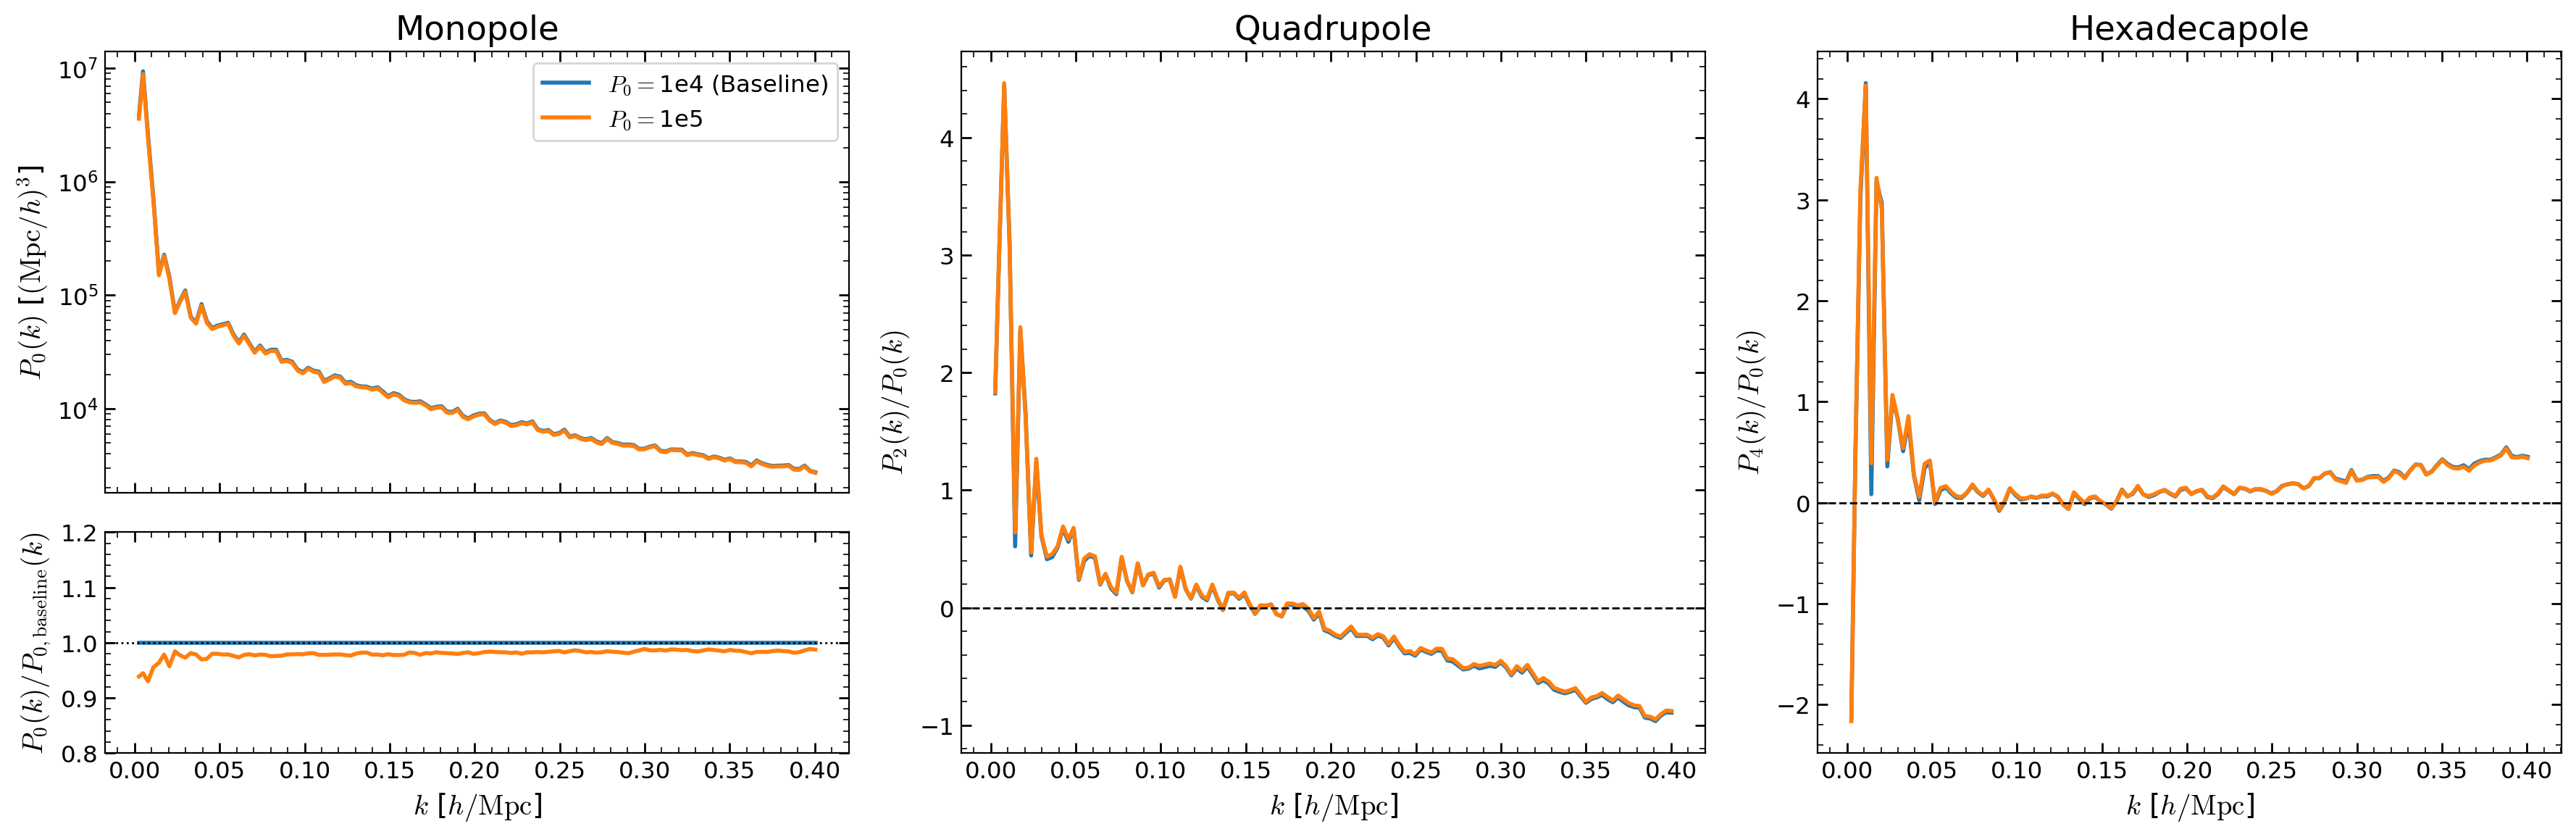

In [ ]:
from matplotlib import gridspec

# --- 1. Create Figure with a custom GridSpec layout ---
fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(2, 3, height_ratios=[2, 1])

# Create the axes for the four plots
ax_pk0 = fig.add_subplot(gs[0, 0])          # Top-left for raw monopole
ax_ratio = fig.add_subplot(gs[1, 0], sharex=ax_pk0)  # Bottom-left for ratio
ax_pk2 = fig.add_subplot(gs[:, 1])          # Middle, spanning both rows
ax_pk4 = fig.add_subplot(gs[:, 2])          # Right, spanning both rows

# Hide x-tick labels on the top-left plot to avoid overlap
plt.setp(ax_pk0.get_xticklabels(), visible=False)

# --- 2. Define a Baseline for Comparison ---
# configs[0]['name']
baseline_name = '$P_0=$1e4 (Baseline)'  # configs[0]['name']
k_base, pk0_base = results[baseline_name](ell=0, return_k=True)

# --- 3. Loop Through and Plot Each Result ---
for name, poles in results.items():
    print(name)
    k, pk0 = poles(ell=0, return_k=True)
    _, pk2 = poles(ell=2, return_k=True)
    _, pk4 = poles(ell=4, return_k=True)

    # Plot 1a: Raw Monopole (top-left)
    ax_pk0.plot(k, pk0, label=name)

    # Plot 1b: Monopole Ratio (bottom-left)
    ax_ratio.plot(k, pk0 / pk0_base)

    # Plot 2: Quadrupole / Monopole (middle)
    ax_pk2.plot(k, pk2 / pk0)

    # Plot 3: Hexadecapole / Monopole (right)
    ax_pk4.plot(k, pk4 / pk0)

# --- 4. Finalize Plot Formatting ---
# Raw Monopole Plot
ax_pk0.set_title('Monopole')
ax_pk0.set_ylabel(r'$P_0(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
ax_pk0.legend()
ax_pk0.semilogy()

# Monopole Ratio Plot
ax_ratio.set_ylabel(r'$P_0(k) / P_{0, \mathrm{baseline}}(k)$')
ax_ratio.axhline(1, color='k', linestyle=':', lw=1)
ax_ratio.set_ylim(0.8, 1.2)  # Zoom in to see small differences
ax_ratio.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')

# Quadrupole Plot
ax_pk2.set_title('Quadrupole')
ax_pk2.set_ylabel(r'$P_2(k) / P_0(k)$')
ax_pk2.axhline(0, color='k', linestyle='--', lw=1)
ax_pk2.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')

# Hexadecapole Plot
ax_pk4.set_title('Hexadecapole')
ax_pk4.set_ylabel(r'$P_4(k) / P_0(k)$')
ax_pk4.axhline(0, color='k', linestyle='--', lw=1)
ax_pk4.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

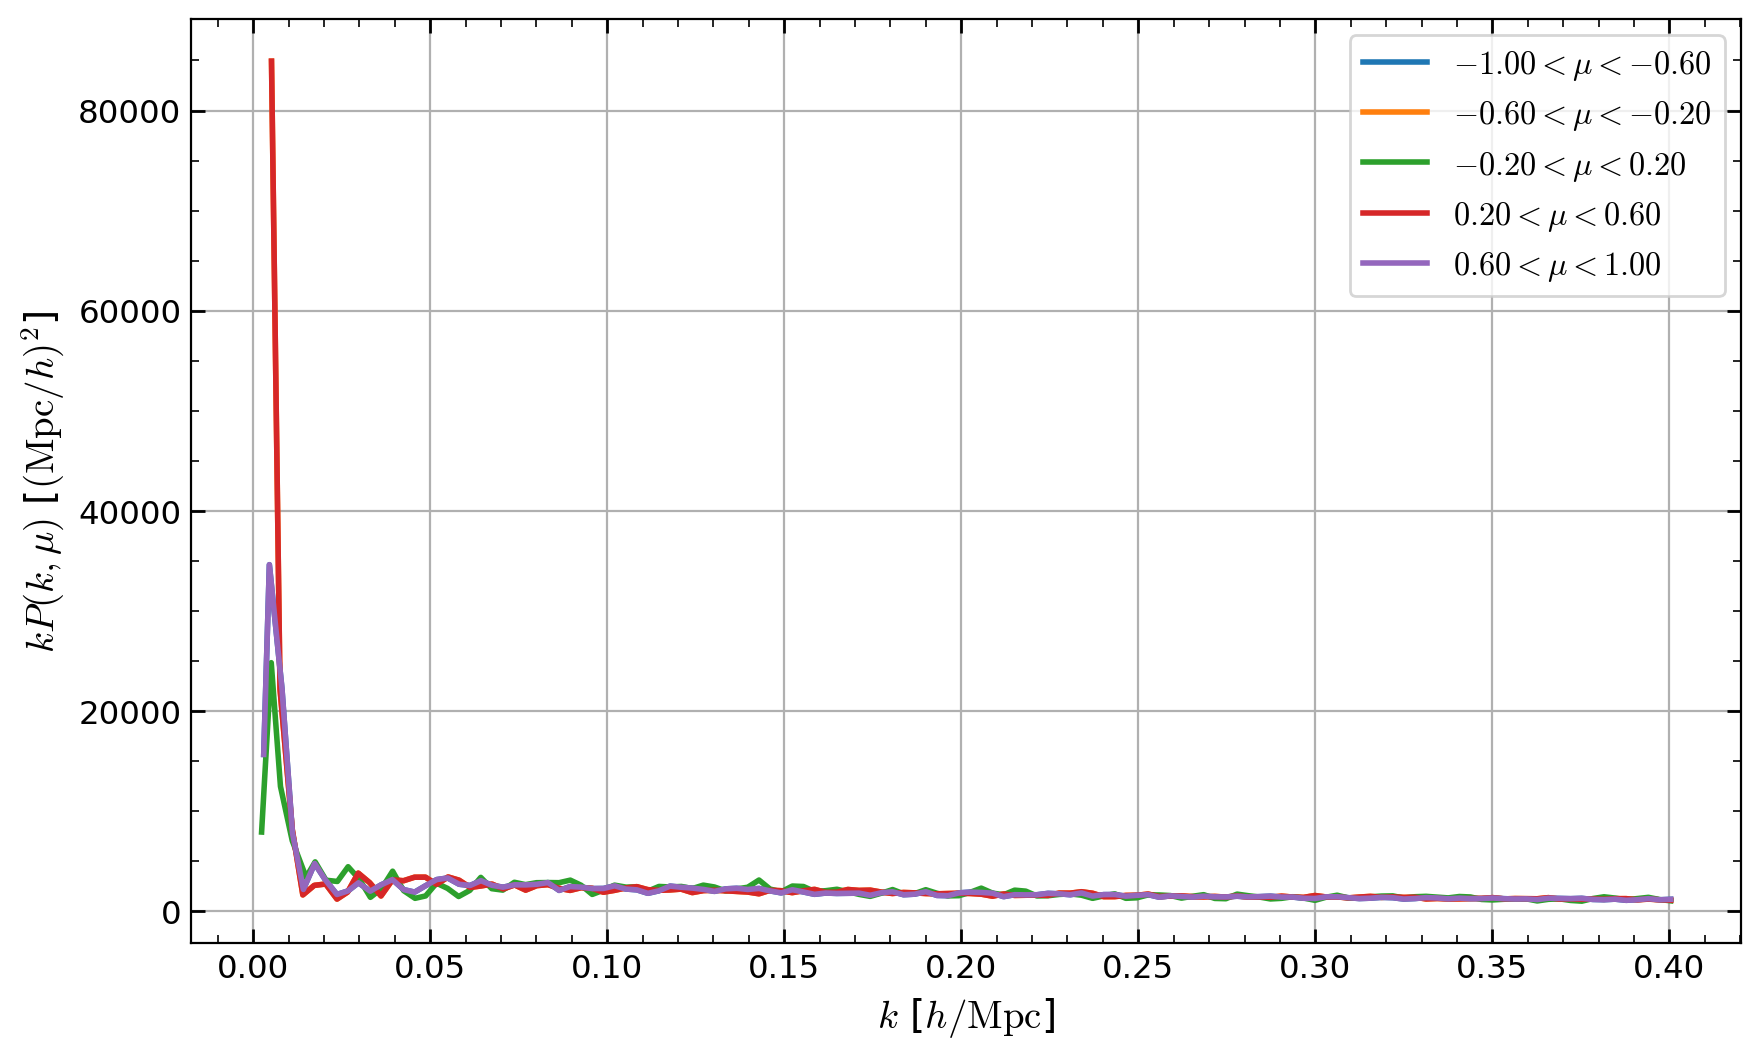

In [ ]:
result = CatalogFFTPower(
    data_positions1=data_positions,
    data_weights1=data_w,
    randoms_positions1=randoms_positions,
    randoms_weights1=randoms_w,
    edges=(kedges, np.linspace(-1, 1, 6)),
    ells=ells,
    **final_params  # Unpack the remaining, valid pypower parameters
)
result.wedges.plot(show=True)

/home/x-mho1/.conda/envs/2024.02-py311/pmesh/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/x-mho1/.conda/envs/2024.02-py311/pmesh/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


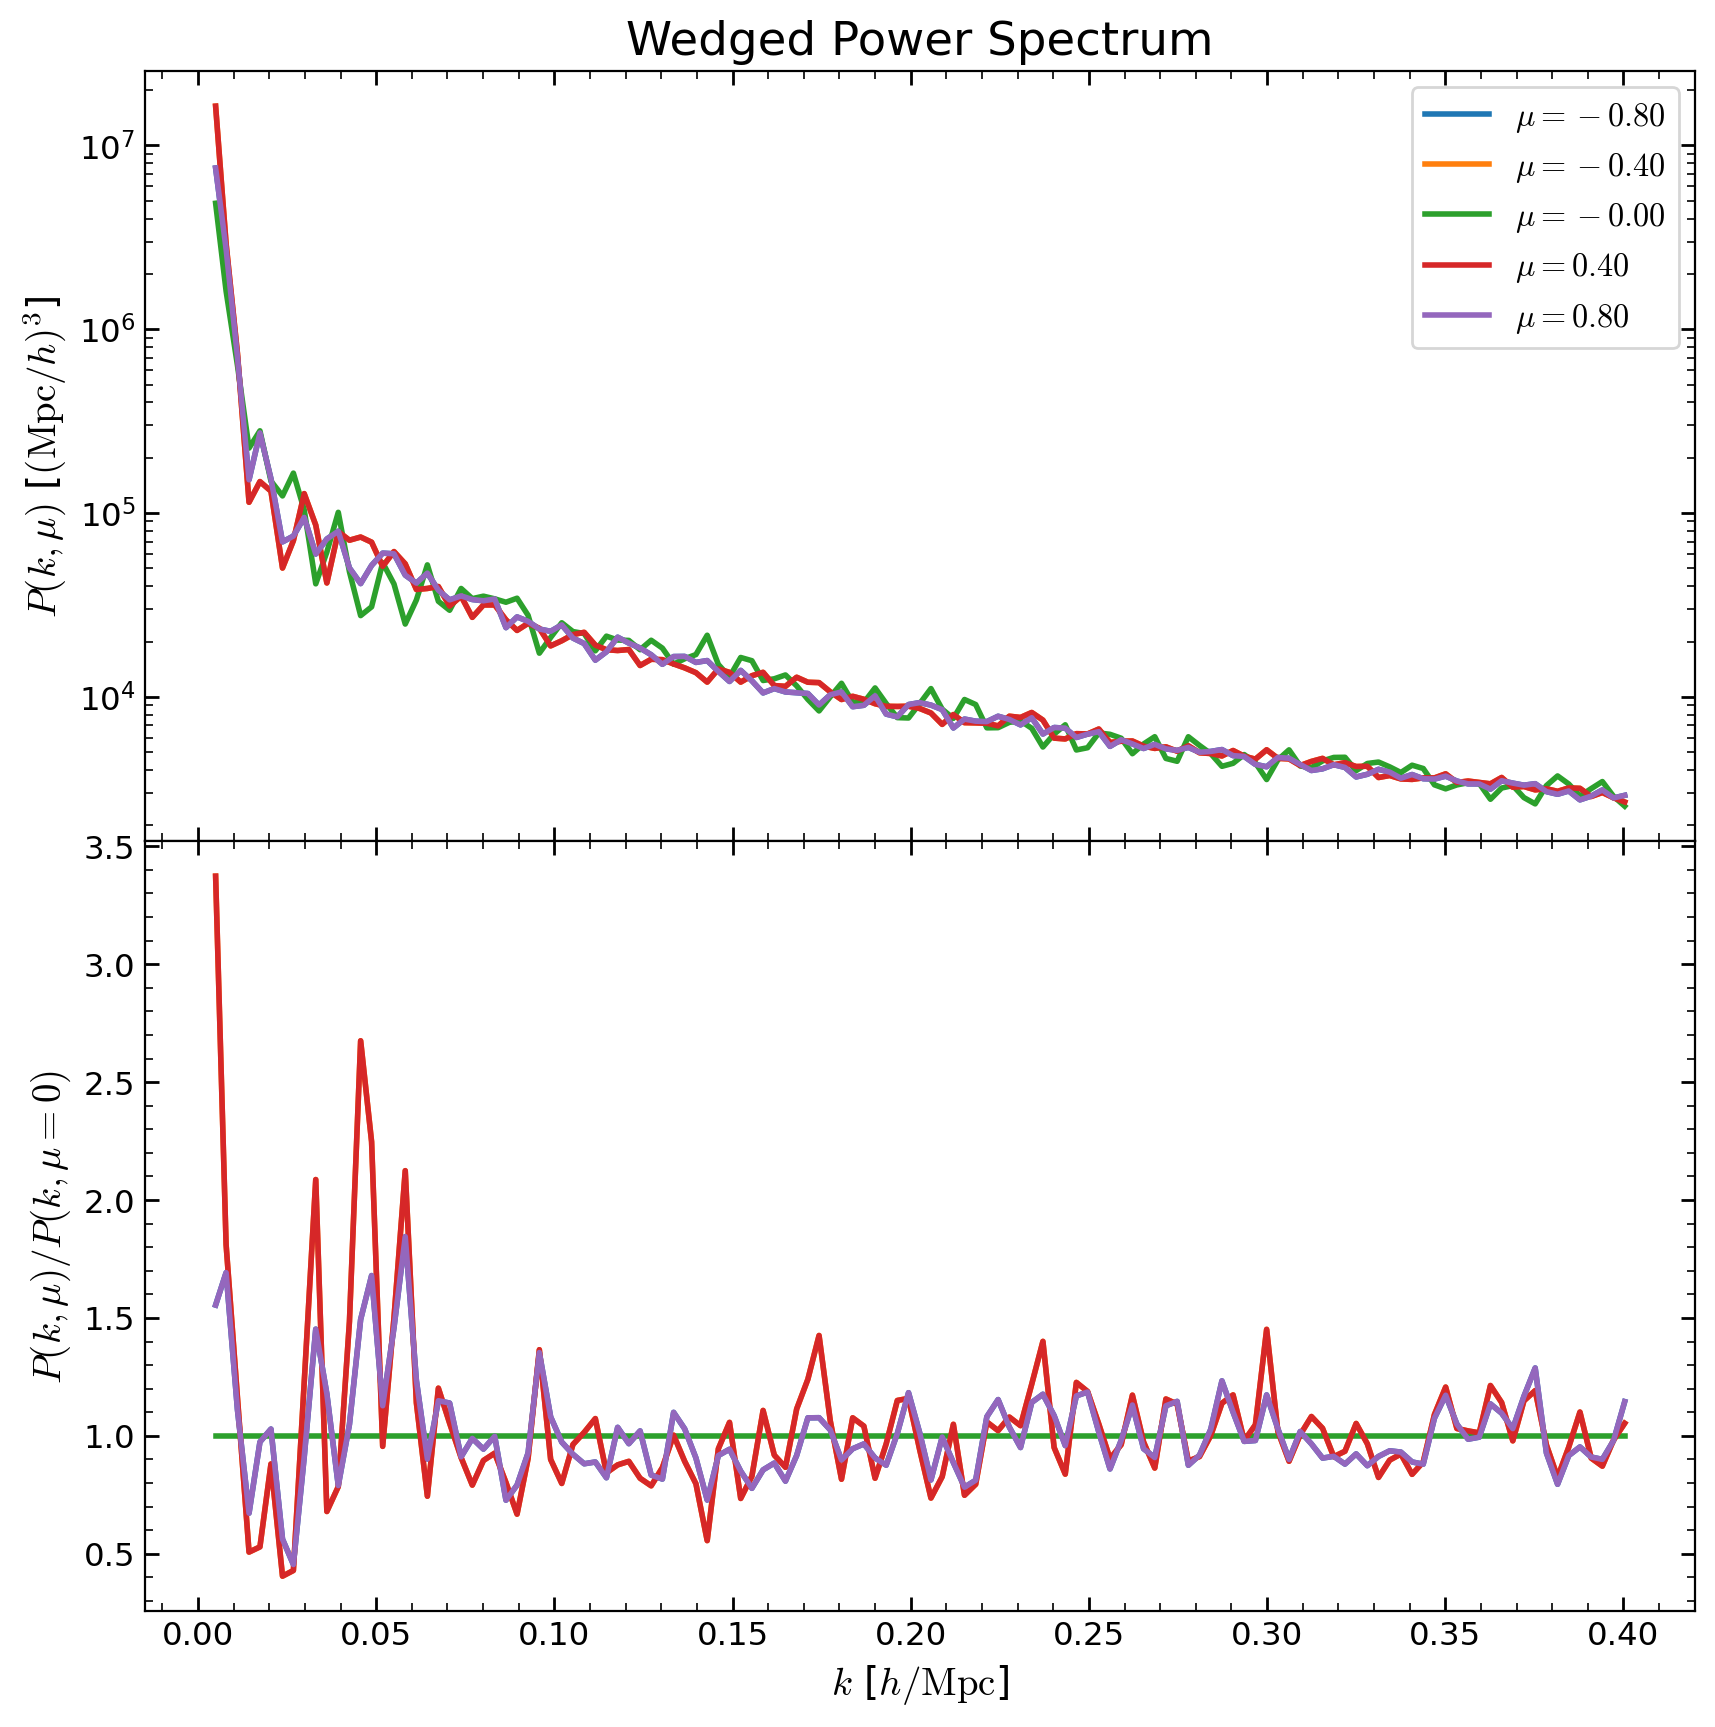

In [ ]:
wedges = result.wedges

baseline = wedges(mu=0, return_k=False)
f, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True,
                      gridspec_kw=dict(hspace=0))
for imu, mu in enumerate(wedges.muavg):
    ax = axs[0]
    ax.plot(*wedges(mu=mu, return_k=True, complex=False),
            label=r'$\mu = {:.2f}$'.format(mu))

    ax = axs[1]
    k, pk = wedges(mu=mu, return_k=True, complex=False)
    ax.plot(k, pk/baseline, label=r'$\mu = {:.2f}$'.format(mu))

axs[0].semilogy()
axs[0].set_title('Wedged Power Spectrum')
axs[0].set_ylabel(r'$P(k, \mu)$ [$(\mathrm{Mpc}/h)^{3}$]')
axs[1].set_ylabel(r'$P(k, \mu) / P(k, \mu=0)$')
axs[1].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
axs[0].legend()

## Read outputs

In [3]:
lhid = 663
filename = f'/ocean/projects/phy240015p/mho1/cmass-ili/abacuslike/fastpm_recnoise_rot/L2000-N256/{lhid}/diag/sgc_lightcone/hod00001_aug00001.h5'
data = {}
with h5py.File(filename, 'r') as f:
    for k, v in f.items():
        data[k] = v[:]
        print(f'{k}: {v.shape} {v.dtype}')
    for k, v in f.attrs.items():
        if k == 'config':
            continue
        print(f'{k}: {v}')
# print(data['Pk_k3D'][-5:])

m = data['Pk_k3D'] < 0.5
data['Pk_k3D'] = data['Pk_k3D'][m]
data['Pk'] = data['Pk'][m]

Bk: (1, 1245) float32
Bk_k123: (3, 1245) float32
Pk: (173, 3) float64
Pk_k3D: (173,) float64
Qk: (1, 1245) float32
bPk: (3, 1245) float32
bPk_k3D: (3, 1245) float32
nz: (100,) int64
nz_bins: (101,) float64
HOD_model: zheng07zinterp
HOD_names: ['alpha' 'conc_gal_bias_satellites' 'eta_vb_centrals' 'eta_vb_satellites'
 'logM0_z0' 'logM0_z1' 'logM0_z2' 'logM1_z0' 'logM1_z1' 'logM1_z2'
 'logMmin_z0' 'logMmin_z1' 'logMmin_z2'
 'mean_occupation_centrals_assembias_param1'
 'mean_occupation_satellites_assembias_param1' 'sigma_logM']
HOD_params: [ 1.55050689e-01  1.98603388e+00  3.55682491e-01  1.41205057e+00
  1.48755178e+01  1.49246461e+01  1.46341500e+01  1.30802997e+01
  1.47092271e+01  1.37264436e+01  1.22180602e+01  1.33670125e+01
  1.21380700e+01 -1.02803659e-02 -3.52100009e-01  5.47165369e-01]
HOD_seed: 6630001
Ngalaxies: 504001
boxsize: 2664.0625
cosmo_names: ['Omega_m' 'Omega_b' 'h' 'n_s' 'sigma8']
cosmo_params: [0.3223  0.04625 0.7015  0.9607  0.8311 ]
high_res: False
log10nbar: -4.57

In [5]:
data['Qk'].shape

(1, 1237)

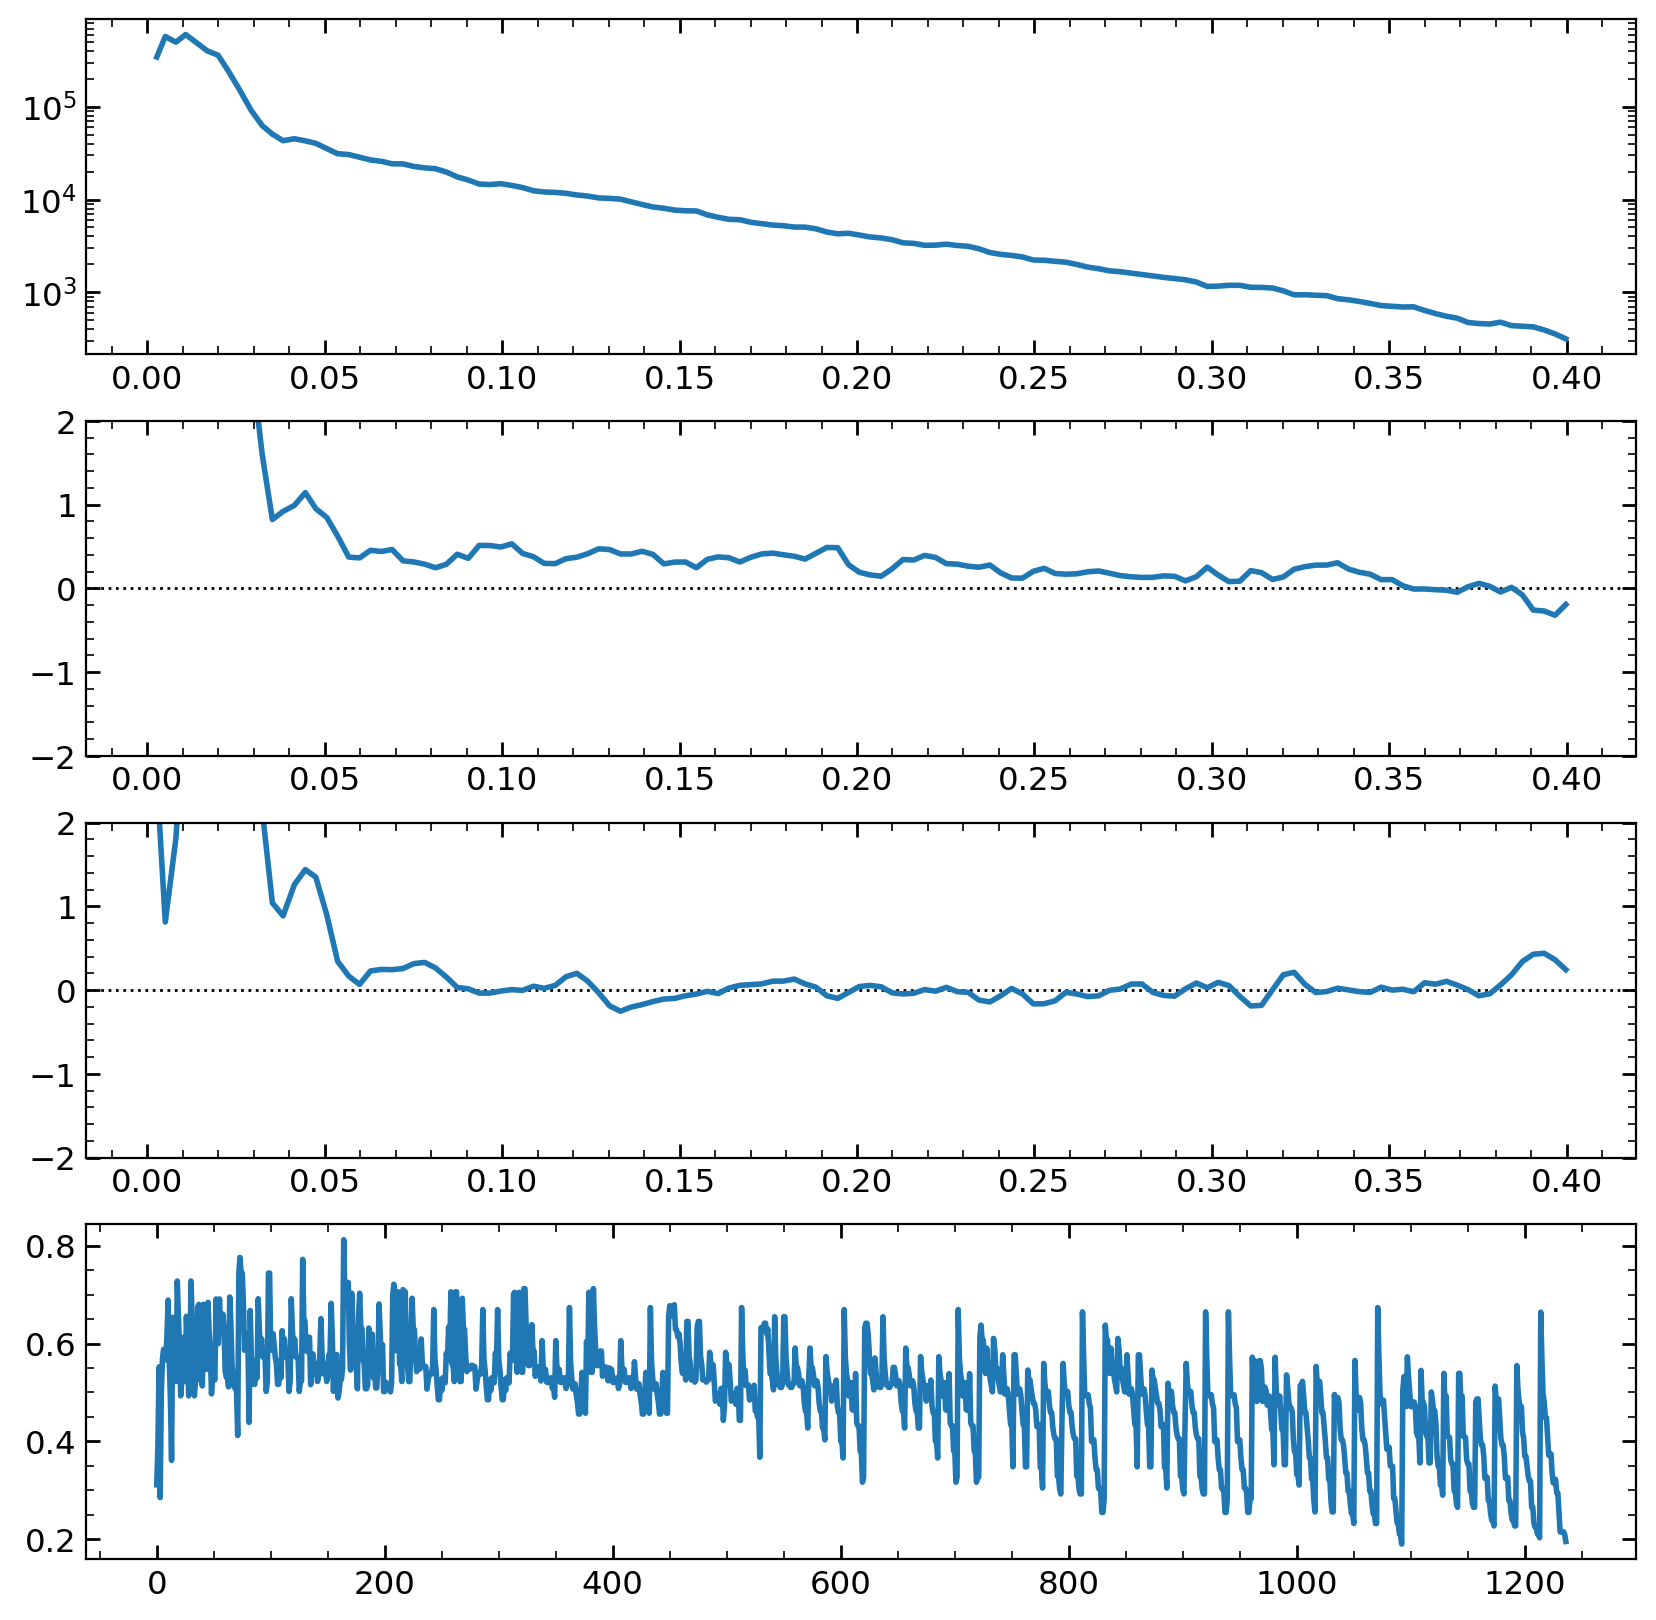

In [65]:
f, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=False,)

ax = axs[0]
ax.semilogy(data['Pk_k3D'], data['Pk'][:, 0])

ax = axs[1]
ax.axhline(0, color='k', linestyle=':', lw=1)
ax.plot(data['Pk_k3D'], data['Pk'][:, 1]/data['Pk'][:, 0])
ax.set_ylim(-2, 2)

ax = axs[2]
ax.axhline(0, color='k', linestyle=':', lw=1)
ax.plot(data['Pk_k3D'], data['Pk'][:, 2]/data['Pk'][:, 0])
ax.set_ylim(-2, 2)

ax = axs[3]
ax.plot(data['Qk'][0])

In [66]:
# lhid = 662
filename = f'/ocean/projects/phy240015p/mho1/cmass-ili/abacuslike/fastpm_recnoise_rot/L2000-N256/{lhid}/simbig_lightcone/hod00001_aug00001.h5'
obs = {}
with h5py.File(filename, 'r') as f:
    for k, v in f.items():
        obs[k] = v[:]

Text(0.5, 0, 'Redshift')

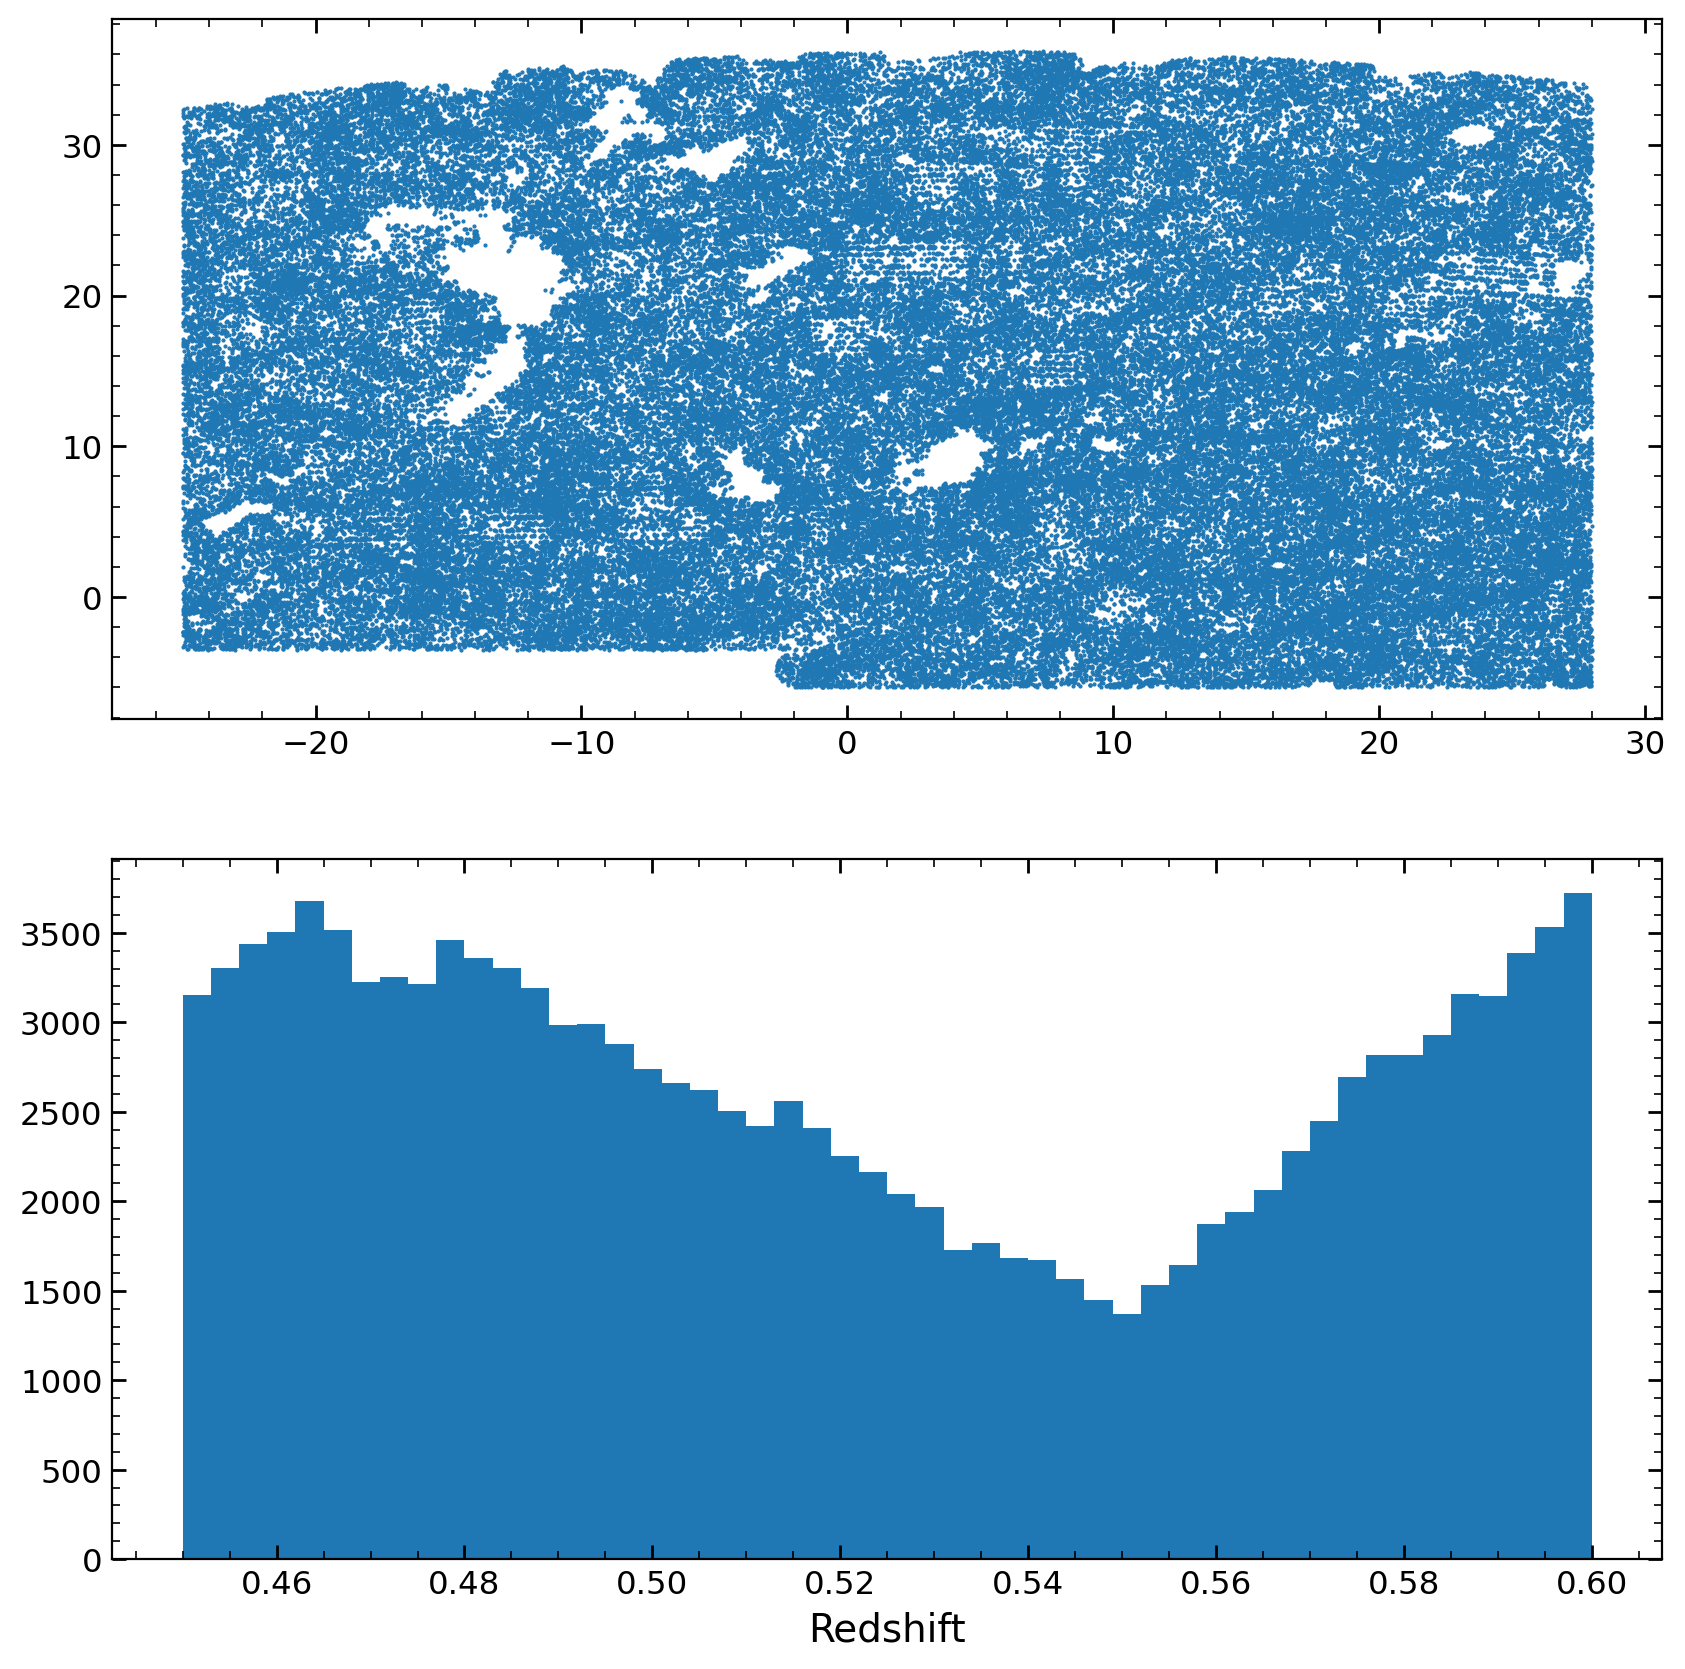

In [67]:
f, axs = plt.subplots(2, 1, figsize=(10, 10))
ax = axs[0]
ax.plot((obs['ra']+180) % 360-180, obs['dec'], '.', markersize=1)
ax = axs[1]
ax.hist(obs['z'], bins=50)
ax.set_xlabel('Redshift')

## Calculate fsky

In [1]:
import numpy as np
import healpy as hp


def calculate_sky_fraction_healpix(ra, dec, nside=128):
    """
    Calculates the sky fraction using the HEALPix method.

    Args:
        ra (array): Right Ascension coordinates in degrees.
        dec (array): Declination coordinates in degrees.
        nside (int): The resolution of the HEALPix grid.
                     Higher nside means smaller, more numerous pixels.

    Returns:
        float: The fraction of the sky covered by the sample.
    """
    # Convert RA and Dec from degrees to radians
    theta = np.deg2rad(90.0 - dec)
    phi = np.deg2rad(ra)

    # Find the unique HEALPix pixels that contain galaxies
    pixel_indices = hp.ang2pix(nside, theta, phi)
    unique_pixels = np.unique(pixel_indices)

    # The sky fraction is the ratio of occupied pixels to the total number of pixels
    sky_fraction = len(unique_pixels) / hp.nside2npix(nside)

    return sky_fraction


nside = 128
print(f'nside: {nside}, Npix: {hp.nside2npix(nside)}')

# --- SGC ---
filename = '/ocean/projects/phy240015p/mho1/cmass-ili/real_data/cmass_sgc/L2000-N256/0/sgc_lightcone/hod00000_aug00000.h5'
with h5py.File(filename, 'r') as f:
    ra = f['ra'][:]
    dec = f['dec'][:]
f_sky = calculate_sky_fraction_healpix(ra, dec, nside=nside)
print(f"SGC Sky Fraction (f_sky): {f_sky:.4f}")

# --- NGC ---
filename = '/ocean/projects/phy240015p/mho1/cmass-ili/real_data/cmass_ngc/L3000-N384/0/ngc_lightcone/hod00000_aug00000.h5'
with h5py.File(filename, 'r') as f:
    ra = f['ra'][:]
    dec = f['dec'][:]
f_sky = calculate_sky_fraction_healpix(ra, dec, nside=nside)
print(f"NGC Sky Fraction (f_sky): {f_sky:.4f}")

# --- MTNG ---
filename = '/ocean/projects/phy240015p/mho1/cmass-ili/mtng/nbody/L3000-N384/0/mtng_lightcone/hod00000_aug00000.h5'
with h5py.File(filename, 'r') as f:
    ra = f['ra'][:]
    dec = f['dec'][:]
f_sky = calculate_sky_fraction_healpix(ra, dec, nside=nside)
print(f"MTNG Sky Fraction (f_sky): {f_sky:.4f}")

# --- SIMBIG ---
filename = '/ocean/projects/phy240015p/mho1/cmass-ili/abacuslike/fastpm_recnoise_rot/L2000-N256/663/simbig_lightcone/hod00001_aug00001.h5'
with h5py.File(filename, 'r') as f:
    ra = f['ra'][:]
    dec = f['dec'][:]
f_sky = calculate_sky_fraction_healpix(ra, dec, nside=nside)
print(f"SIMBIG Sky Fraction (f_sky): {f_sky:.4f}")

nside: 128, Npix: 196608


NameError: name 'h5py' is not defined

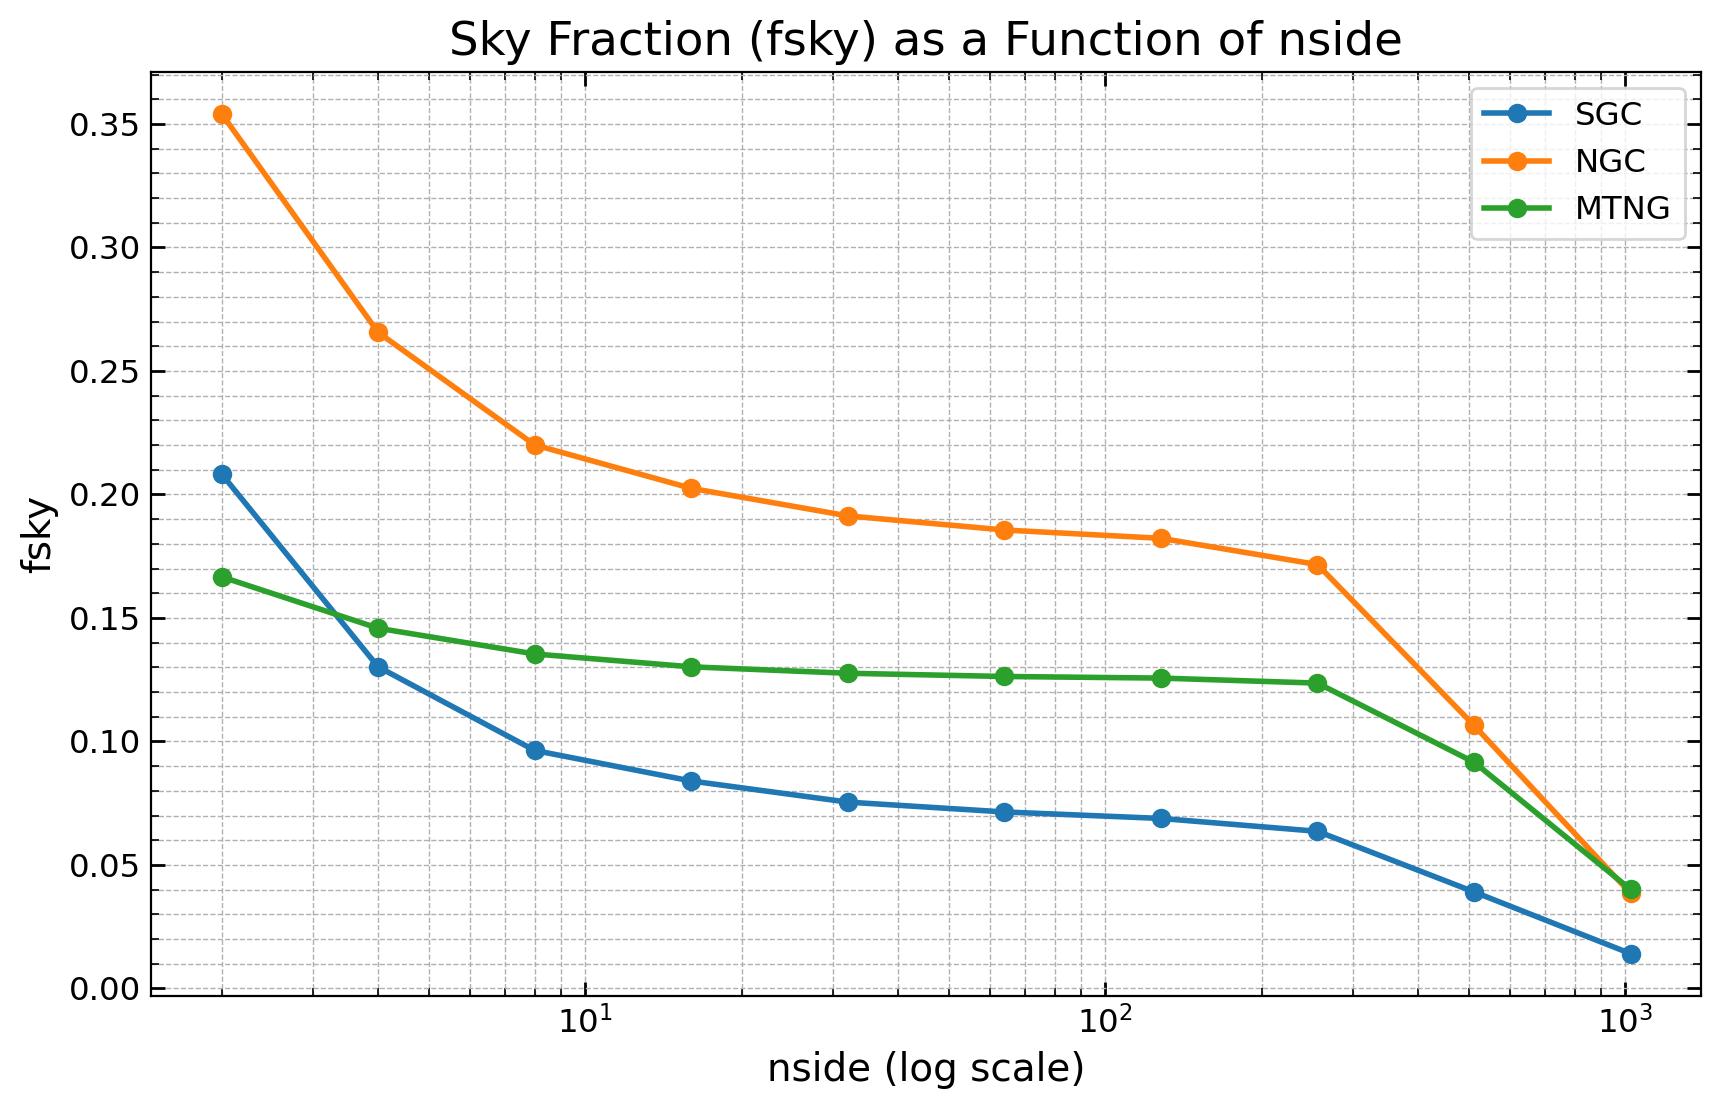

In [ ]:
# Define a function to calculate fsky for a range of nside values
def calculate_fsky_vs_nside(ra, dec, nsides):
    fsky_values = []
    for nside in nsides:
        fsky = calculate_sky_fraction_healpix(ra, dec, nside=nside)
        fsky_values.append(fsky)
    return fsky_values


# Define the range of nside values to test
nsides = [2**i for i in range(1, 11)]  # nside values from 2 to 1024

# Calculate fsky for each survey
surveys = {
    "SGC": '/ocean/projects/phy240015p/mho1/cmass-ili/real_data/cmass_sgc/L2000-N256/0/sgc_lightcone/hod00000_aug00000.h5',
    "NGC": '/ocean/projects/phy240015p/mho1/cmass-ili/real_data/cmass_ngc/L3000-N384/0/ngc_lightcone/hod00000_aug00000.h5',
    "MTNG": '/ocean/projects/phy240015p/mho1/cmass-ili/mtng/nbody/L3000-N384/0/mtng_lightcone/hod00000_aug00000.h5'
}

fsky_results = {}
for survey, filepath in surveys.items():
    with h5py.File(filepath, 'r') as f:
        ra = f['ra'][:]
        dec = f['dec'][:]
    fsky_results[survey] = calculate_fsky_vs_nside(ra, dec, nsides)

# Plot the results
f, ax = plt.subplots(figsize=(10, 6))
for survey, fsky_values in fsky_results.items():
    ax.plot(nsides, fsky_values, label=survey, marker='o')

ax.set_xscale('log')
ax.set_xlabel('nside (log scale)')
ax.set_ylabel('fsky')
ax.set_title('Sky Fraction (fsky) as a Function of nside')
ax.legend()
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

## Test attributes

In [23]:
from collections import defaultdict
import os
suitepath = '/ocean/projects/phy240015p/mho1/cmass-ili/mtnglike/fastpm_recnoise_rot/L3000-N384'

out = defaultdict(lambda: [])
for i in tqdm(os.listdir(suitepath)):
    if not i.isdigit():
        continue
    lhid = int(i)
    tracer = 'sgc_lightcone'
    filename = f'{suitepath}/{lhid}/diag/{tracer}/hod00001_aug00001.h5'
    try:
        with h5py.File(filename, 'r') as f:
            for key in ['Ngalaxies', 'boxsize', 'nbar']:
                out[key].append(f.attrs[key])
        out['lhid'].append(lhid)
    except Exception as e:
        pass

100%|██████████| 3000/3000 [00:02<00:00, 1185.81it/s]


Text(0.5, 1.0, 'sgc_lightcone boxsize')

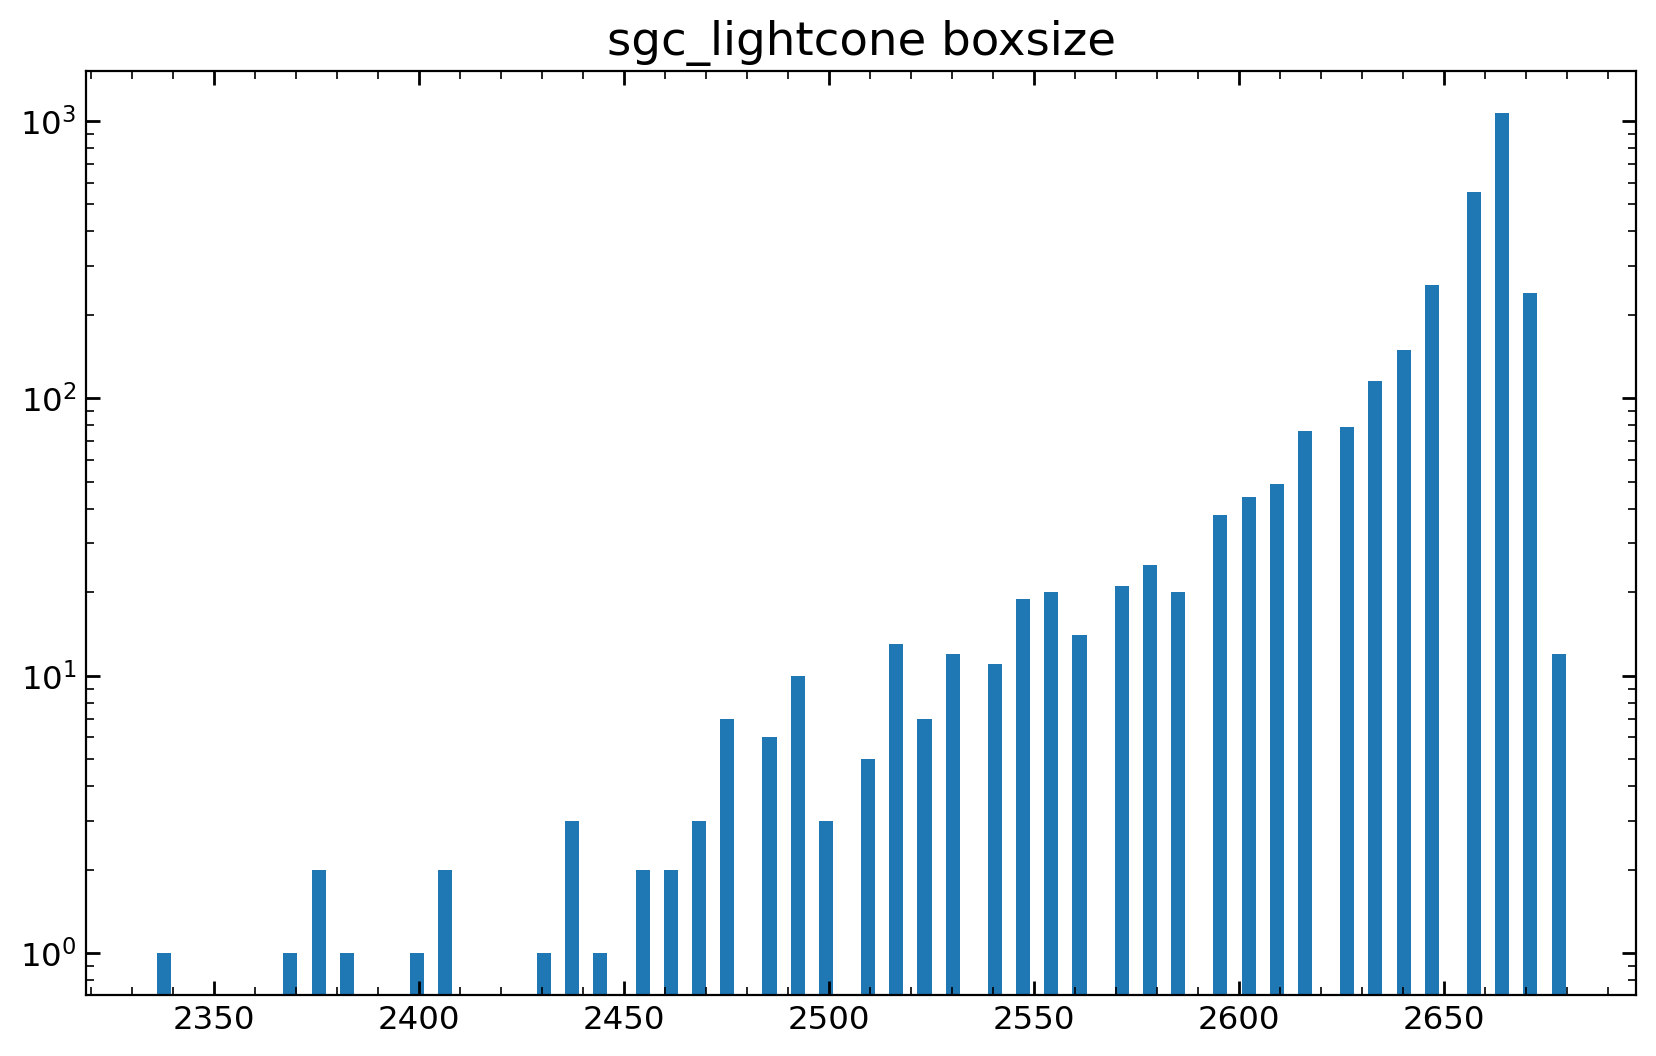

In [ ]:
f, ax = plt.subplots()

key = 'boxsize'
ax.hist(out[key], bins=100, log=True)
ax.set_title(f'{tracer} {key}')

In [30]:
(10*3*2+11)*3000

213000